In [1]:
from neuprint import Client
from neuprint import NeuronCriteria as NC
from neuprint import fetch_neurons
from neuprint import fetch_adjacencies
from neuprint.utils import connection_table_to_matrix
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import hvplot.pandas
import holoviews as hv
import numpy as np
import pandas as pd
import ants
import nibabel as nib
import os
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from fa2 import ForceAtlas2
from nxviz import CircosPlot
import nxviz as nv
import tqdm
import time
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [47]:
connectome_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'

In [48]:
#########################
### load cells in FDA ###
#########################

load_file = os.path.join(connectome_dir, 'synpervox.npy')
synpervox = np.load(load_file)

In [49]:
#############################
### load synapses and ids ###
#############################

file = os.path.join(connectome_dir,'hemibrain_all_neurons_synapses_polypre_centrifugal_synapses.pickle')
file = open(file, 'rb')
synapses = pickle.load(file)
cell_ids = np.unique(synapses['bodyid'])

In [4]:
################
### Load FDA ###
################

def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

# hemibrain bounding box
start = {'x': 46, 'y': 5, 'z': 5}
stop = {'x': 147, 'y': 89, 'z': 34}

FDA_crop = FDA_lowres[start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

In [120]:
####################################
### Load temporal filters in FDA ###
####################################

save_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220919_temporal_filters_in_FDA"
filters = {}
for beh in [0,1,2,3]:
    savefile = os.path.join(save_dir, F"filters_{beh}.npy")
    filters[beh] = np.load(savefile)
    filters[beh] = filters[beh][start['x']:stop['x'],
                     start['y']:stop['y'],
                     start['z']:stop['z']]

In [10]:
filters[0].shape

(101, 84, 29, 500)

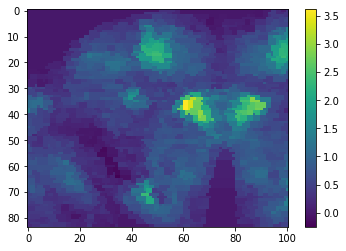

In [37]:
plt.imshow(filters[0][:,:,15,250].T)
plt.colorbar()

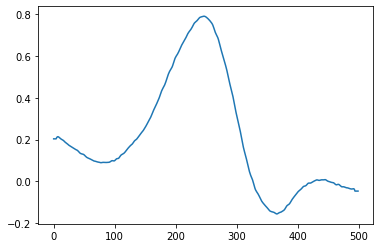

In [33]:
plt.plot(filters[0][50,50,15,:])

In [39]:
np.min(filters[0]), np.max(filters[0])

(-0.5075146, 3.6632013)

In [65]:
DNa02_R = "1140245595"
idx = np.where(cell_ids==DNa02_R)[0][0]
DNa02_mask = synpervox[idx,...].astype('float')
#DNa02_mask[np.where(DNa02_mask<1)] = np.nan

DNa02_mask[np.where(DNa02_mask<1)] = 0
DNa02_mask[np.where(DNa02_mask>1)] = 1

In [66]:
DNa02_mask.shape

(101, 84, 29)

(100, 400)

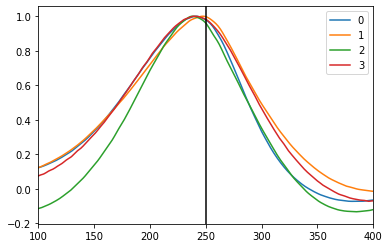

In [181]:
DNa02_R = "1140245595"
idx = np.where(cell_ids==DNa02_R)[0][0]
DNa02_mask = synpervox[idx,...].astype('float')
DNa02_mask[np.where(DNa02_mask<10)] = 0
DNa02_mask[np.where(DNa02_mask>10)] = 1

avg_filters = []
for beh in [0,1,2,3]:
    avg_filter = np.mean(DNa02_mask[...,np.newaxis]*filters[beh],axis=(0,1,2))
    plt.plot(avg_filter/np.max(avg_filter),label=beh)
    avg_filters.append(avg_filter/np.max(avg_filter))
plt.axvline(250,color='k')
plt.legend()
plt.xlim(100,400)
#plt.axvline(240)
#25 is 500ms
#or, 20ms per bin
# bigger numbers mean neural first

In [178]:
out = scipy.signal.deconvolve(avg_filters[0], avg_filters[1])

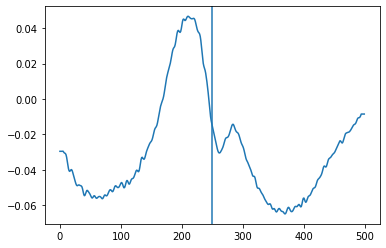

In [184]:
plt.plot(avg_filters[3]-avg_filters[1])
plt.axvline(250)

In [67]:
filters[0].shape

(101, 84, 29, 500)

In [144]:
tp = 240
filters_ = filters[1].copy()
filters_[np.where(filters[1][...,tp]<1)] = 0
filters_[np.where(filters_==0)] = np.nan

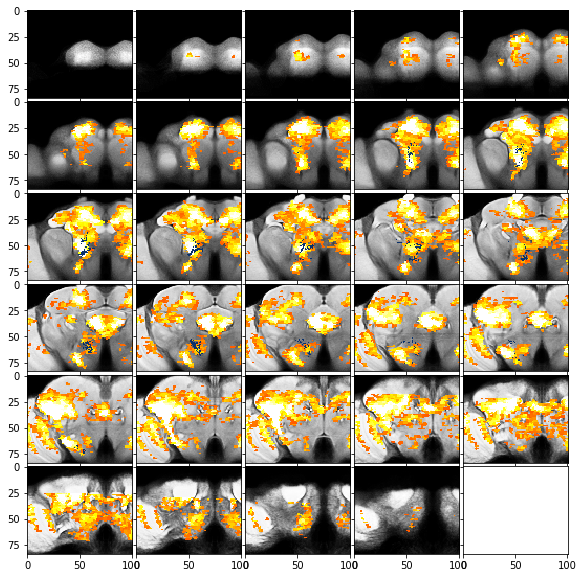

In [161]:
DNa02_R = "1140245595"
idx = np.where(cell_ids==DNa02_R)[0][0]
DNa02_mask = synpervox[idx,...].astype('float')
DNa02_mask[np.where(DNa02_mask<10)] = np.nan

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_crop[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(filters_[:,:,z,tp].T,cmap='hot',vmin=0,vmax=2)
    grid[z].imshow(DNa02_mask[:,:,z].T,cmap='Blues',vmin=0,vmax=1)

In [189]:
import matplotlib.colors as mcolors

In [205]:
filters_ = filters[1]-filters[0]

In [210]:
peaks = np.argmax(filters_,axis=-1)
peaks[np.where(np.max(filters_,axis=-1)<.5)] = 0

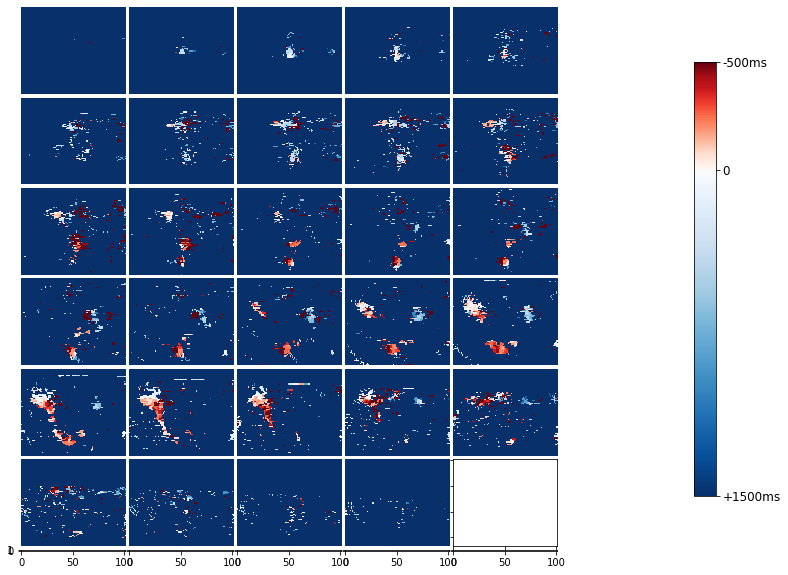

In [211]:
start = 275
end = 175
middle = 250


# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mymap.set_bad(color='grey')

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
for i in range(29):
    cax = grid[i].imshow(peaks[:,:,i].T,cmap=mymap,vmin=end,vmax=start);
    #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet',vmin=end,vmax=start);
    grid[i].axis('off')

cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
cbar.ax.set_yticklabels(['-500ms', '0', '+1500ms'], fontsize=12)

#     cbar = fig.colorbar(cax, ticks=[start, end],shrink=.8, anchor=(.1,.5))
#     cbar.ax.set_yticklabels(['+300ms', '+1000ms'], fontsize=12)

#plt.suptitle(f'{behs[beh_idx]}',y=.93)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')